In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from astroquery.esa.euclid.core import EuclidClass, Euclid
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D
from multiprocessing.pool import ThreadPool
from astropy import wcs
from astropy.io import fits
import numpy as np
import pandas as pd
#import sep
import glob
import os
import warnings

from astropy.wcs import WCS
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astropy.table import Table
from astropy.visualization import astropy_mpl_style, ImageNormalize, ZScaleInterval, PercentileInterval, AsinhStretch, SqrtStretch, SquaredStretch
plt.style.use(astropy_mpl_style)
pd.set_option('display.max_colwidth', 0) #to show full column content (no wrapping and no dots)

/tmp/ipykernel_1550/1562636954.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
import morphology_utils
import cutout_utils
import pipeline_utils


In [5]:
# change to your username
Euclid.login(user='mwalms01')

INFO: Login to Euclid TAP server [astroquery.esa.euclid.core]


Password:  ········


INFO: OK [astroquery.utils.tap.core]
INFO: Login to Euclid data service [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to Euclid cutout service [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]


In [6]:
tile_index = 102010567

In [7]:
query_str = f"""
SELECT * FROM sedm.mosaic_product 
WHERE (tile_index='{tile_index}')
AND (filter_name='VIS')
"""
print(query_str)
job = Euclid.launch_job(query_str)
tile = job.results.to_pandas().squeeze()
# add ra/dec limits (approx)
tile = pipeline_utils.get_tile_extents(tile, pipeline_utils.WIDE)


SELECT * FROM sedm.mosaic_product 
WHERE (tile_index='102010567')
AND (filter_name='VIS')



In [10]:
# # galaxies in a tile
# df = pd.read_csv('/media/home/team_workspaces/Galaxy-Zoo-Euclid/data/pipeline/catalogs/102010567_mer_catalog.csv')


current_cuts = pipeline_utils.find_zoobot_sources_in_tile(tile)  # or more
current_cuts.head() 

Found 568  query results


,object_id,right_ascension,declination,gaia_id,segmentation_area,flux_segmentation,flux_vis_aper,ellipticity,kron_radius,tile_index,mag_segmentation
0,-825099872609351172,82.509987,-60.935117,<NA>,1621,8.100384,3.676997,0.612469,343.52072,102010567,21.628736
1,-825074455609237973,82.507446,-60.923797,<NA>,1427,27.669592,27.485040,0.123238,60.99424,102010567,20.294993
2,-825048429610336803,82.504843,-61.033680,<NA>,2724,42.491856,38.310570,0.178640,91.18531,102010567,19.829236
3,-825027680610713459,82.502768,-61.071346,<NA>,1553,14.710961,14.771809,0.096731,74.72672,102010567,20.980897
4,-825024730609984736,82.502473,-60.998474,<NA>,3295,56.085426,49.793396,0.194263,95.95038,102010567,19.527875


In [12]:
query_str = f"""
            SELECT right_ascension, declination, segmentation_area, kron_radius, ellipticity, flux_segmentation, object_id, spurious_prob, vis_det, det_quality_flag, flag_vis, flag_y
            FROM catalogue.mer_catalogue
            WHERE gaia_id IS NULL
            AND vis_det=1
            AND spurious_prob < 0.2
            AND right_ascension > {tile['ra_min']} AND right_ascension < {tile['ra_max']}
            AND declination > {tile['dec_min']} AND declination < {tile['dec_max']}
            AND (segmentation_area > 1200 OR flux_segmentation > 22.90867652)
            """
# 'http error detected' means log in again, above
Euclid.launch_job_async(query_str, background=False, dump_to_file=True, output_file='latest_mer_catalogue.csv', output_format='csv')
df = pd.read_csv('latest_mer_catalogue.csv', dtype={'object_id': str})
df['tile_index'] = tile_index
df['mag_segmentation'] = -2.5 * np.log10(df['flux_segmentation']) + 23.9  # total vis mag in segmention mask
len(df)



568

In [14]:
# out of interest, what does it look like without the tile limits? i.e. how many galaxies in total will we label?

query_str = f"""SELECT object_id, right_ascension, declination, gaia_id, segmentation_area, flux_segmentation, flux_vis_aper, ellipticity, kron_radius
                FROM catalogue.mer_catalogue
                WHERE flux_vis_aper > 0
                AND gaia_id IS NULL
                AND vis_det=1
                AND spurious_prob < 0.2
                AND (segmentation_area > 1200 OR flux_segmentation > 22.90867652)
            """
Euclid.launch_job_async(query_str, background=False, dump_to_file=True, output_file='latest_mer_catalogue.csv', output_format='csv')
df = pd.read_csv('latest_mer_catalogue.csv', dtype={'object_id': str})
df['tile_index'] = tile_index
df['mag_segmentation'] = -2.5 * np.log10(df['flux_segmentation']) + 23.9  # total vis mag in segmention mask
len(df)





820075

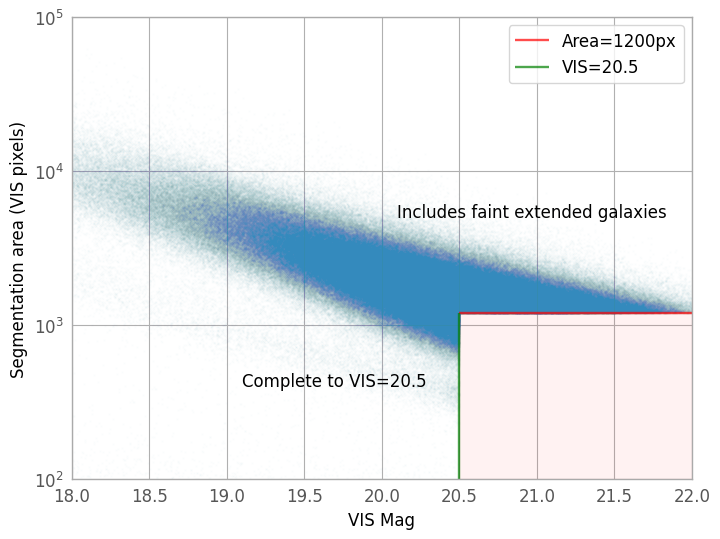

In [18]:

fig, ax = plt.subplots()
ax.scatter(df['mag_segmentation'], df['segmentation_area'], alpha=.01, s=.5)
ax.set_yscale('log')
plt.xlabel('VIS Mag')
plt.ylabel('Segmentation area (VIS pixels)')
x_min = 18
x_max = 22
y_min = 10**2
y_max = 10**5
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.hlines(1200, 20.5, x_max, linestyle='-', alpha=.7, color='r', label='Area=1200px')
ax.vlines(20.5, y_min, 1200, linestyle='-', alpha=.7, color='g', label='VIS=20.5')


alpha = .05
color = 'r'
select_x = np.linspace(x_min, x_max)
# select_x_low = select_x[select_x < 20.5]
# select_x_high = np.concatenate([select_x_low[-1].reshape(1), select_x[select_x >= 20.5]])

# ax.fill_between(select_x, np.where(select_x < 20.5, x_min, 1200), y_max, color=color, alpha=alpha)
select_x = np.linspace(20.5, x_max)
ax.fill_between(select_x, y_min, 1200, color=color, alpha=alpha)
ax.text(19.1, 400, 'Complete to VIS=20.5')
ax.text(20.1, 5000, 'Includes faint extended galaxies')
# ax.text(20.1, 5000, 'Dropped', color='r')

plt.legend(loc='upper right')

In [19]:
df.query('segmentation_area < 1200')['mag_segmentation'].max()

20.499997939670177

In [149]:
x = 20.5
10 ** ( (x - 23.9) / (-2.5) )

22.908676527677702

## Your turn

In [150]:
df_subset = df.copy()
# TODO apply your own selection cuts on galaxies_in_tile
# TODO add new columns using the query above, if helpful


# for example
# df_subset = df_subset.query('mag_segmentation < 24')
# print((df_subset['spurious_prob'] > 0.2).mean())
# df_subset = df_subset.query('spurious_prob > 0.2')  # what do the spurious detections look like?

# df_subset = df_subset.query('segmentation_area > 1200').query('mag_segmentation > 20.5')

#query('mag_segmentation < 21.5')



In [151]:
# leave this part alone

cutout_folder = '/media/home/team_workspaces/Galaxy-Zoo-Euclid/cutout_experiments'
df_subset['cutout_loc'] = df_subset.apply(lambda x: pipeline_utils.get_cutout_loc(cutout_folder, x, output_format='jpg'), axis=1)

In [152]:
len(df_subset)

568

In [153]:
# copied here from pipeline_utils

vis_loc = '/media/home/team_workspaces/Galaxy-Zoo-Euclid/data/pipeline/tiles/EUC_MER_BGSUB-MOSAIC-VIS_TILE102010567-EE51A8_20240306T053728.760996Z_00.00.fits'
nisp_loc = '/media/home/team_workspaces/Galaxy-Zoo-Euclid/data/pipeline/tiles/EUC_MER_BGSUB-MOSAIC-NIR-Y_TILE102010567-EBC499_20240306T040953.226005Z_00.00.fits'
vis_data, header = fits.getdata(vis_loc, header=True, memmap=False, decompress_in_memory=True)
nisp_data = fits.getdata(nisp_loc, header=False)
tile_wcs = WCS(header)

In [154]:
df_vis = df_subset.sample(20).reset_index(drop=True)

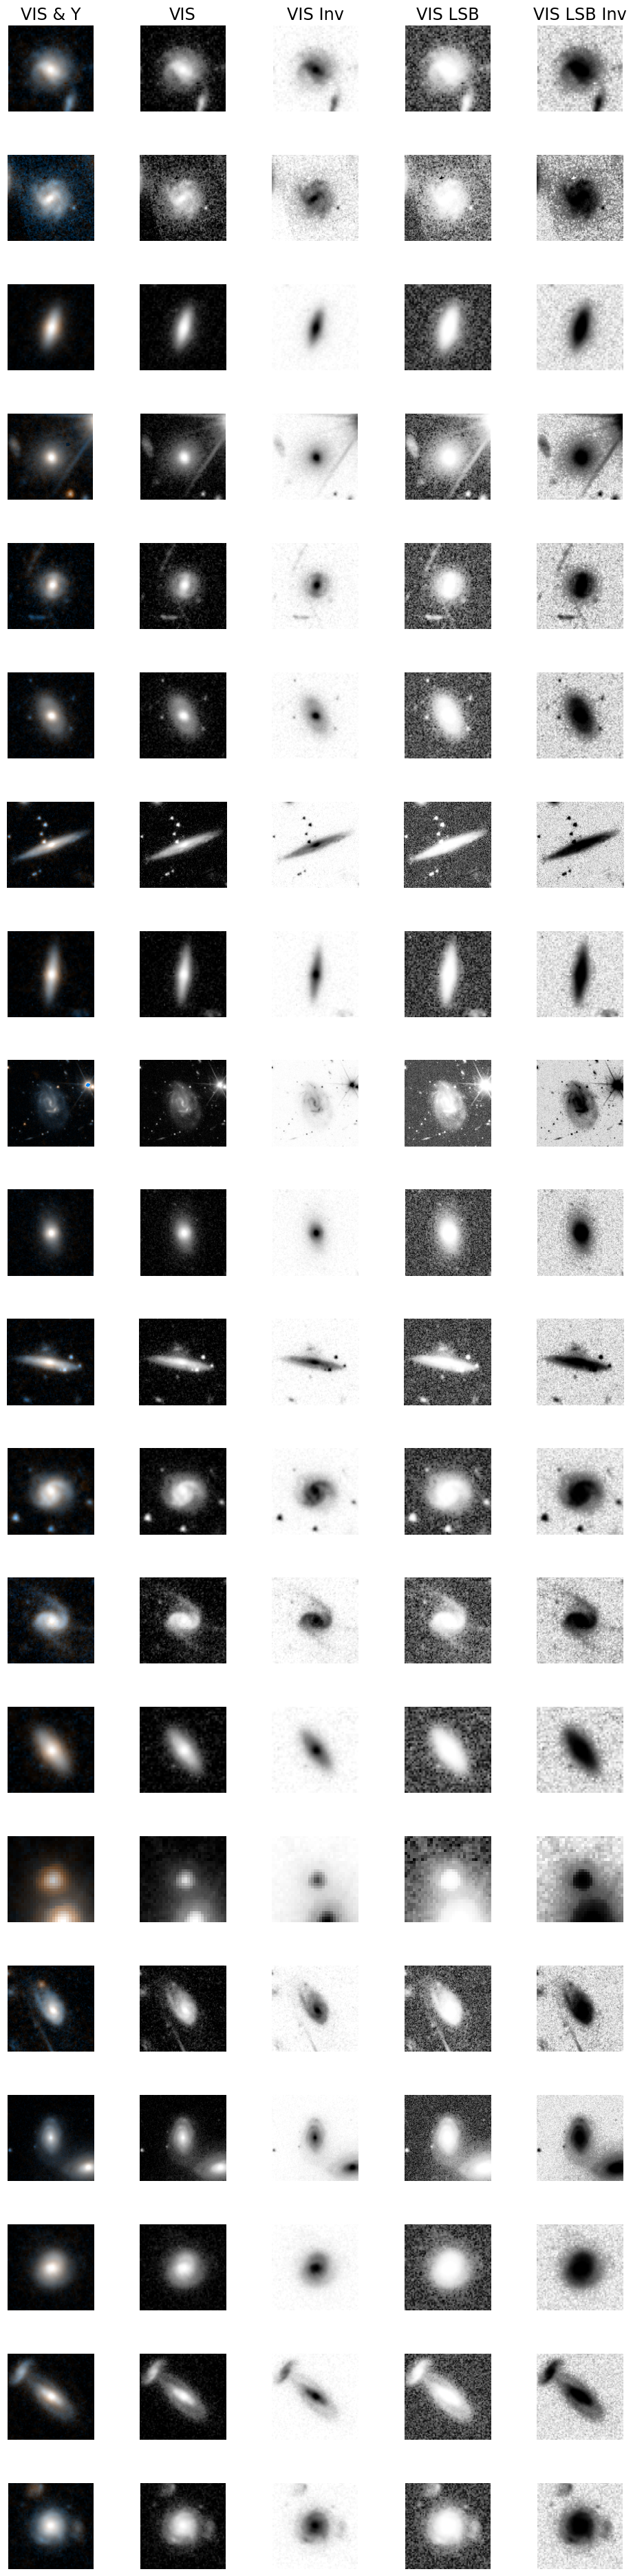

In [155]:
# fig, rows = plt.subplots(nrows=10, ncols=3, figsize=(7, 24))
fig, rows = plt.subplots(nrows=20, ncols=5, figsize=(12, 48))


for row_n, row in enumerate(rows):

    galaxy = df_vis.iloc[row_n]
    # cutout_loc = get_cutout_loc(base_dir, galaxy, output_format)
    
    if row_n == 0:
        row[0].set_title('VIS & Y')
        row[1].set_title('VIS')
        row[2].set_title('VIS Inv')
        row[3].set_title('VIS LSB')
        row[4].set_title('VIS LSB Inv')

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        c = SkyCoord(galaxy['right_ascension'], galaxy['declination'], frame='icrs', unit="deg")
        x_center, y_center = tile_wcs.world_to_pixel(c)
        galaxy['x_center'] = x_center  
        galaxy['y_center'] = y_center
        galaxy['log_segmentation_area'] = np.log10(galaxy['segmentation_area'])
        galaxy['log_kron_radius'] = np.log10(galaxy['kron_radius'])

        galaxy.index = galaxy.index.str.upper()  # for consistency w/ MER pipeline key names


        cutout = cutout_utils.make_composite_cutout(galaxy, vis_data, nisp_data, allow_radius_estimate=True)
        row[0].imshow(cutout)
        row[0].axis('off')
        
        cutout = morphology_utils.make_vis_only_cutout(galaxy, vis_data, allow_radius_estimate=True)
        row[1].imshow(cutout, cmap='Greys_r')
        row[1].axis('off')
        row[2].imshow(cutout, cmap='Greys')
        row[2].axis('off')
        
        cutout = cutout_utils.make_lsb_cutout(galaxy, vis_data, nisp_data, stretch=20, power=0.5, allow_radius_estimate=True)
        row[3].imshow(cutout, cmap='Greys_r')
        row[3].axis('off')
        row[4].imshow(cutout, cmap='Greys')
        row[4].axis('off')
        
        


In [37]:
cutout.shape

(69, 70)

In [ ]:
# fig, axes = plt.subplots(ncols=8, nrows=4, figsize=(14, 8))
# axes = axes.flatten()
# for ax_n, ax in enumerate(axes):
#     try:
#         im = Image.open(df_to_visualise['cutout_loc'][ax_n])
#         ax.imshow(im)
#     except KeyError:
#         pass  # out of galaxies
#     ax.axis('off')
# # yep, these spurious_prob all seem like 'galaxies' worth dropping! Thanks Teymoor :)

In [ ]:
# pd.crosstab(df['spurious_prob'] > 0.2, df['vis_det'] == 1)